In [1]:
import pickle
import sys
from typing import List

import torch

import numpy as np
from dataclasses import dataclass
from matplotlib import pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import umap

sys.path.insert(0, 'third_party/CenterNet2/projects/CenterNet2/')
from centernet.config import add_centernet_config  # type: ignore
from detectron2.utils.visualizer import ColorMode
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

import pandas as pd
import cv2

from grit.modeling.meta_arch.grit import GRiT
from grit.predictor import Visualizer_GRiT
from main import get_model

output_notebook()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading BokehJS ...

In [2]:
@dataclass
class ModelArgs:
    config_file: str
    test_task: str
    opts: List[str]
    confidence_threshold: float = 0.5


args_densecap = ModelArgs(
    config_file='config/GRiT_B_DenseCap_ObjectDet.yaml',
    test_task="DenseCap",
    opts=["MODEL.WEIGHTS", "models/grit_b_densecap_objectdet.pth"]
)

args_objectdet = ModelArgs(
    config_file='config/GRiT_B_DenseCap_ObjectDet.yaml',
    test_task="ObjectDet",
    opts=["MODEL.WEIGHTS", "models/grit_b_densecap_objectdet.pth"]
)

model_densecap, input_format, aug = get_model(args_densecap)
model_objectdet, _, _ = get_model(args_objectdet)

In [ ]:
with open('step_data.pickle', 'rb') as handle:
    step_data = pickle.load(handle)

print(step_data[0].keys())

In [3]:
with open('step_data_height.pickle', 'rb') as handle:
    height_step_data = pickle.load(handle)

print(height_step_data[0].keys())
print(len(height_step_data.keys()))

dict_keys(['pc', 'rgb', 'boxes', 'boxes_samples', 'scores', 'descriptions', 'object_features'])
9


/home/markus/miniconda3/envs/gritty/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/markus/miniconda3/envs/gritty/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


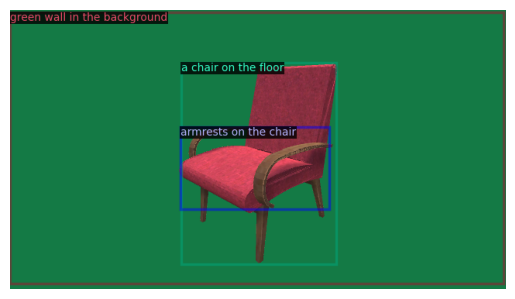

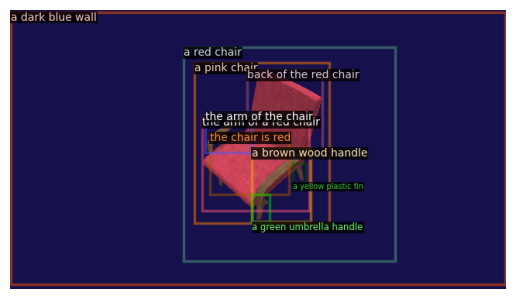

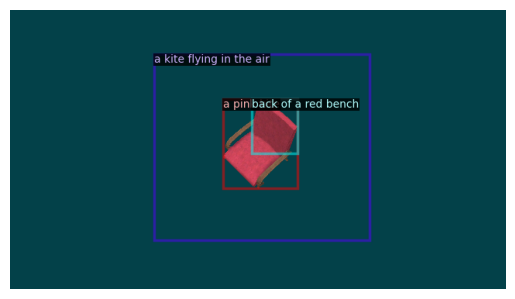

In [4]:
def show_image(rgb_img: torch.tensor):
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        # if input_format == "RGB":
        #     # whether the model expects BGR inputs or RGB
        #     rgb_img = rgb_img[:, :, ::-1]
        original_height, original_width = rgb_img.shape[:2]

        image = aug.get_transform(rgb_img).apply_image(rgb_img)
        image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
        inputs = [{"image": image, "height": original_height, "width": original_width}]

        images = model_densecap.preprocess_image(inputs)
        features = model_densecap.backbone(images.tensor)
        proposals, _ = model_densecap.proposal_generator(images, features, None)
        # next line is the forward call to GRIT_ROI_HEAD -> text decoder
        results, _ = model_densecap.roi_heads(
            features,
            proposals,
        )
        previous_pred_instances = results[0]
        predictions = GRiT._postprocess(results, inputs, images.image_sizes)

        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        # cv2.imshow('x', rgb_img)|
        # Convert image from OpenCV BGR format to Matplotlib RGB format.
        image = rgb_img[:, :, ::-1]
        visualizer = Visualizer_GRiT(image, instance_mode=ColorMode.IMAGE)
        instances = predictions[0]["instances"].to("cpu")
        vis_image = visualizer.draw_instance_predictions(predictions=instances)

        plt.figure()
        plt.axis('off')
        plt.imshow(vis_image.get_image())

show_image(height_step_data[1]['rgb'])
show_image(height_step_data[4]['rgb'])
show_image(height_step_data[8]['rgb'])

In [ ]:
rgb_img = step_data[8]['rgb']
print(input_format)

with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    # if input_format == "RGB":
    #     # whether the model expects BGR inputs or RGB
    #     rgb_img = rgb_img[:, :, ::-1]
    original_height, original_width = rgb_img.shape[:2]

    image = aug.get_transform(rgb_img).apply_image(rgb_img)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    inputs = [{"image": image, "height": original_height, "width": original_width}]

    images = model_densecap.preprocess_image(inputs)
    features = model_densecap.backbone(images.tensor)
    proposals, _ = model_densecap.proposal_generator(images, features, None)
    # next line is the forward call to GRIT_ROI_HEAD -> text decoder
    results, _ = model_densecap.roi_heads(
        features,
        proposals,
    )
    previous_pred_instances = results[0]
    predictions = GRiT._postprocess(results, inputs, images.image_sizes)

    print(rgb_img[10][10])
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
    # cv2.imshow('x', rgb_img)|
    # Convert image from OpenCV BGR format to Matplotlib RGB format.
    image = rgb_img[:, :, ::-1]
    visualizer = Visualizer_GRiT(image, instance_mode=ColorMode.IMAGE)
    instances = predictions[0]["instances"].to("cpu")
    vis_image = visualizer.draw_instance_predictions(predictions=instances)

    plt.imshow(vis_image.get_image())

In [5]:
print(len(height_step_data.keys()))

# labels:
# 0 right back
# 1 right front
# 2 left front
# 3 left back
# for x in height_step_data.values():
#     labels = []
#
#     for i, samples in enumerate(x['boxes_samples']):
#         center_of_mass = samples.mean(axis=0)
#         # z zero axis is divider..
#         # class 0: z < 0; 1: z >= 0
#         front = center_of_mass[2] < 0
#         right = center_of_mass[0] < 0
#         labels.append(0 if right and not front else 1 if right and front else 2 if not right and front else 3)
#
#     x['labels'] = np.array(labels, dtype=np.uint8)
# labels = [label for x in height_step_data.values() for label in x['labels']]

texts = [description for x in height_step_data.values() for description in x['descriptions'].data]
features = [x['object_features'] for x in height_step_data.values()]

# lens = [len(x['descriptions'].data) for x in step_data.values()]
features = torch.vstack(features)
features = torch.flatten(features, start_dim=1)
print(features.shape)

9
torch.Size([61, 50176])


In [6]:
all_features = [x['object_features'] for x in height_step_data.values()]
all_features = torch.vstack(all_features)
print(all_features.shape)
feature_mean = all_features.mean(axis=0)
print(feature_mean.shape)

torch.Size([61, 196, 256])
torch.Size([196, 256])


In [7]:
prediction = model_densecap.roi_heads.text_decoder(
    {'object_features': feature_mean.unsqueeze(0).cuda()}
)['predictions'][0]
description = model_densecap.roi_heads.tokenizer.decode(prediction.tolist()[1:], skip_special_tokens=True)
print(description)

a red umbrella


In [ ]:
# try to classify the embeddings..
linear_svm = SVC(kernel='linear', C=0.025)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.4, random_state=42
)

clf = make_pipeline(StandardScaler(), linear_svm)
clf.fit(X_train, y_train)
y = clf.predict(features)
score = clf.score(X_test, y_test)
print(score)


In [ ]:
print(features.shape)
print(feature_mean.flatten().shape)
features = torch.cat((features, feature_mean.flatten().unsqueeze(0)))
texts.append(description)
print(features.shape)

In [8]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.4, set_op_mix_ratio=1.0, random_state=42)
reducer.fit(features)

embeddings = reducer.embedding_

In [9]:
digits_df = pd.DataFrame(embeddings, columns=('x', 'y'))
digits_df['text'] = texts
digits_df['color'] = ['green' if 'chair' in text else 'red' for text in texts]
# digits_df['color'][229] = 'black'

datasource = ColumnDataSource(digits_df)
# color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in digits.target_names],
#                                        palette=Spectral10)

plot_figure = figure(
    title='UMAP projection of the Digits dataset',
    width=600,
    height=600,
    tools='pan, wheel_zoom, reset'
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>Text:</span>
        <span style='font-size: 18px'>@text</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='color'),
    # color=dict(field='digit'),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=8
)
show(plot_figure)